In [1]:
from astropy import constants as const
from scipy.stats import stats
import scipy.integrate as integrate
from scipy.stats import norm
from scipy import interpolate
from astropy.io import fits
from astropy import units as u
from iminuit import Minuit
from scipy.optimize import curve_fit
from iminuit.cost import LeastSquares
import numpy as np
import pysynphot as S
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
%%time

NBBANDS=6
band_to_number={'u':0,'g':1,'r':2,'i':3,'z':4,'y4':5}
band_to_number_2={'u':0,'g':1,'r':2,'i':3,'z':4,'y':5}
number_to_band={0:'u',1:'g',2:'r',3:'i',4:'z',5:'y4'}
filtercolor=['blue','green','red','orange','grey','black']
NBCOLORS=NBBANDS-1
number_to_color={0:'U-G',1:'G-R',2:'R-I',3:'I-Z',4:'Z-Y'}
color_to_number={'U-G':0,'G-R':1,'R-I':2,'I-Z':3,'Z-Y':4}
mpl_colors_col=['b','g','r','y','k']

WLMIN=3000. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=11000. # Minimum wavelength : PySynPhot works with Angstrom

NBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth=(WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL=np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom

# LSST collectif surface
Deff=642.3 # effective radius in cm
Seff = np.pi*Deff**2/4  # in cm2
S.refs.setref(area=Seff, waveset=None) # set by default to 6.4230 m2
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, num=NBINS, delta=BinWidth, log=False)
S.refs.showref()

EXPOSURE=30.0    

graphtable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\4cm1612bm_tmg.fits
 comptable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\5182153pm_tmc.fits
thermtable: D:\PYSYN_CDBS\grp\redcat\trds\mtab\3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3000.0, Max: 11000.0, Num: None, Delta: 1.0, Log: False
Wall time: 4.99 ms


# Cadence LMC baseline v1

In [3]:
df = pd.read_csv("Downloads\Cadences dobservation des nuages de Magellan/cadence_lmc_baseline_v1.csv", index_col=0)
df

,observationId,night,observationStartMJD,fiveSigmaDepth,filter,airmass,skyBrightness,seeingFwhmEff,fieldId,fieldRA,fieldDec
0,934,1,59854.385463,21.593537,y,1.240813,18.077206,1.283730,-1,81.586959,-66.516554
1,936,1,59854.386287,21.510902,y,1.289795,17.976992,1.313900,-1,82.257779,-69.379108
2,937,1,59854.386702,21.432884,y,1.346227,17.894386,1.348096,-1,83.188050,-72.229967
3,3045,4,59857.362131,22.986090,z,1.382600,19.148145,0.881487,-1,80.811831,-73.766990
4,3103,4,59857.386839,22.764444,z,1.237434,18.602993,0.854189,-1,82.308664,-66.330677
...,...,...,...,...,...,...,...,...,...,...,...
891,2060333,3447,63269.058829,23.475867,u,1.278024,22.608174,1.180799,-1,85.471063,-68.743581
892,2060366,3447,63269.074276,24.549840,g,1.394360,22.091690,1.028710,-1,83.849276,-74.182487
893,2060368,3447,63269.075104,24.647890,g,1.282391,22.138014,0.978318,-1,85.471063,-68.743581
894,2062061,3449,63271.110220,23.578175,u,1.275128,22.621678,1.079728,-1,84.404241,-65.817402


In [4]:
df_u = df[df["filter"] == 'u']
df_g = df[df["filter"] == 'g']
df_r = df[df["filter"] == 'r']
df_i = df[df["filter"] == 'i']
df_z = df[df["filter"] == 'z']
df_y = df[df["filter"] == 'y']

# Histograms

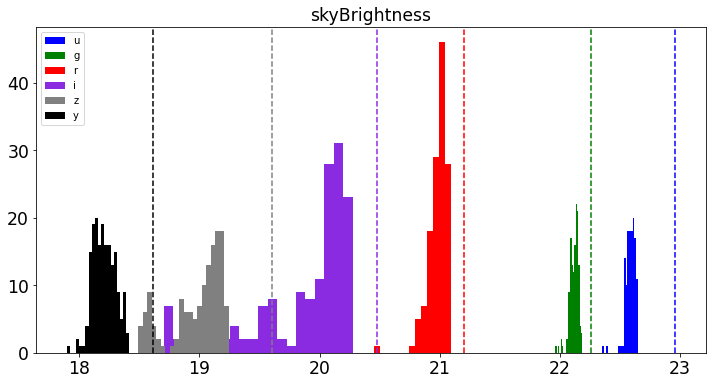

In [5]:
plt.hist(df_u['skyBrightness'], bins = 20, color = 'b', label = 'u');
plt.axvline(22.96, color='b', linestyle='dashed')
plt.hist(df_g['skyBrightness'], bins = 20, color = 'g', label = 'g');
plt.axvline(22.26, color='g', linestyle='dashed')
plt.hist(df_r['skyBrightness'], bins = 20, color = 'r', label = 'r');
plt.axvline(21.20, color='r', linestyle='dashed')
plt.hist(df_i['skyBrightness'], bins = 20, color = 'blueviolet', label = 'i');
plt.axvline(20.48, color='blueviolet', linestyle='dashed')
plt.hist(df_z['skyBrightness'], bins = 20, color = 'grey', label = 'z');
plt.axvline(19.60, color='grey', linestyle='dashed')
plt.hist(df_y['skyBrightness'], bins = 20, color = 'k', label = 'y');
plt.axvline(18.61, color='k', linestyle='dashed')
plt.title("skyBrightness")
plt.legend()

## Dashed line = expected skyBrightness value at zenith, in dark sky

Text(0.5, 0, 'fieldId')

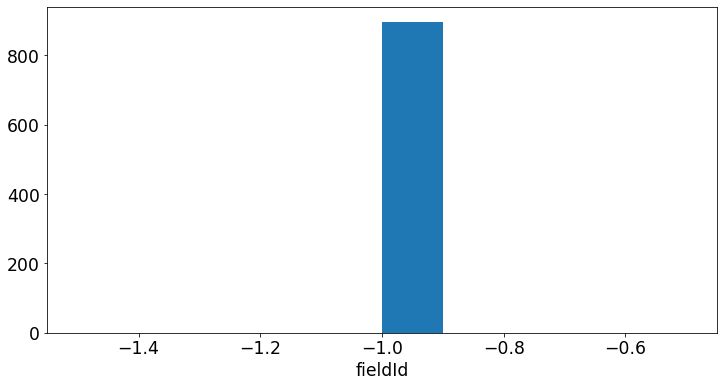

In [6]:
plt.hist(df["fieldId"]);
plt.xlabel("fieldId")

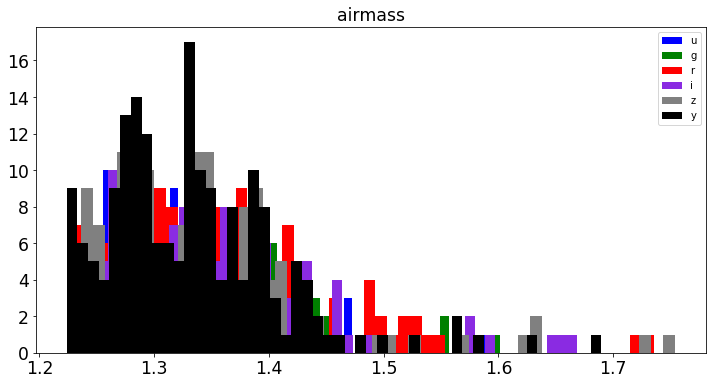

In [7]:
plt.hist(df_u["airmass"], bins = 50, color = 'b', label = 'u');
plt.hist(df_g["airmass"], bins = 50, color = 'g', label = 'g');
plt.hist(df_r["airmass"], bins = 50, color = 'r', label = 'r');
plt.hist(df_i["airmass"], bins = 50, color = 'blueviolet', label = 'i');
plt.hist(df_z["airmass"], bins = 50, color = 'grey', label = 'z');
plt.hist(df_y["airmass"], bins = 50, color = 'k', label = 'y');
plt.title("airmass")
plt.legend()

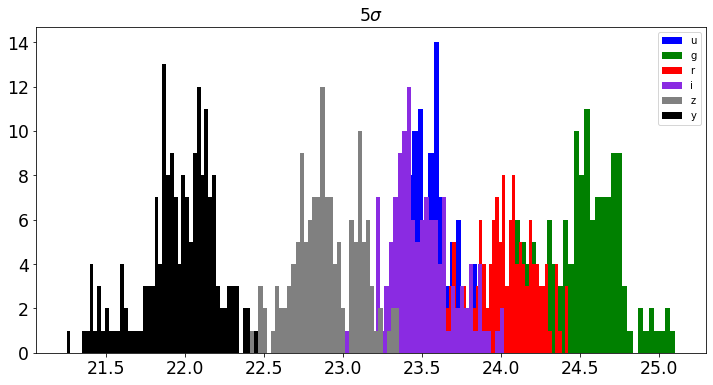

In [8]:
plt.hist(df_u["fiveSigmaDepth"], bins = 50, color = 'b', label = 'u');
plt.hist(df_g["fiveSigmaDepth"], bins = 50, color = 'g', label = 'g');
plt.hist(df_r["fiveSigmaDepth"], bins = 50, color = 'r', label = 'r');
plt.hist(df_i["fiveSigmaDepth"], bins = 50, color = 'blueviolet', label = 'i');
plt.hist(df_z["fiveSigmaDepth"], bins = 50, color = 'grey', label = 'z');
plt.hist(df_y["fiveSigmaDepth"], bins = 50, color = 'k', label = 'y');
plt.title("$5\sigma$")
plt.legend()

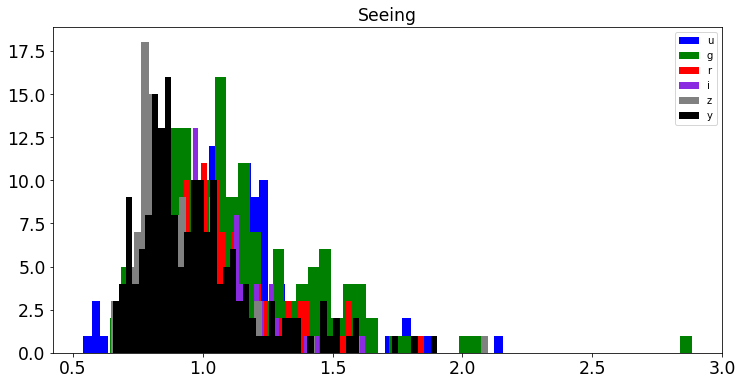

In [9]:
plt.hist(df_u["seeingFwhmEff"], bins = 50, color = 'b', label = 'u');
plt.hist(df_g["seeingFwhmEff"], bins = 50, color = 'g', label = 'g');
plt.hist(df_r["seeingFwhmEff"], bins = 50, color = 'r', label = 'r');
plt.hist(df_i["seeingFwhmEff"], bins = 50, color = 'blueviolet', label = 'i');
plt.hist(df_z["seeingFwhmEff"], bins = 50, color = 'grey', label = 'z');
plt.hist(df_y["seeingFwhmEff"], bins = 50, color = 'k', label = 'y');
plt.title("Seeing")
plt.legend()

# t0 distribution

Wall time: 1.95 s


Text(0.5, 1.0, 'Distribution des $t_0$')

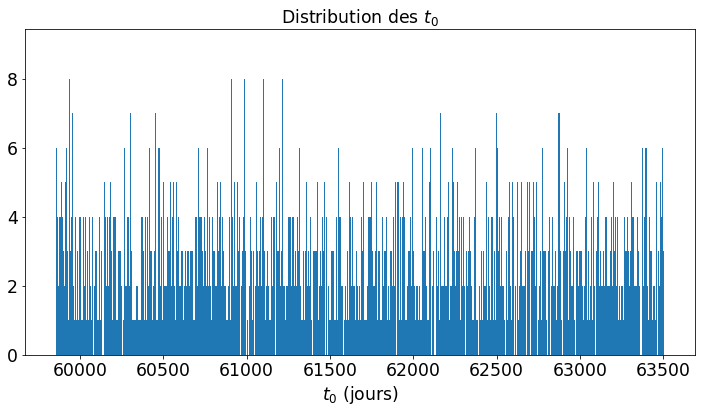

In [10]:
%%time

from scipy.stats import uniform

NYEARS = 10
NDAYS = NYEARS*365.25

xmin = 0
xmax = NDAYS
N=10000 # le nombre de simulation peut être artibrairement tres grand. Ce qui compte c'est de calculer l'efficacité de detection de la courbe de lumière
list_t0 = uniform.rvs(xmin,xmax,N) + df['observationStartMJD'][0]

plt.hist(list_t0,bins=int(NDAYS));
plt.xlabel("$t_0$ (jours)")
plt.title("Distribution des $t_0$")

# u0 distribution

Text(0.5, 1.0, '$u_{min}$ distribution')

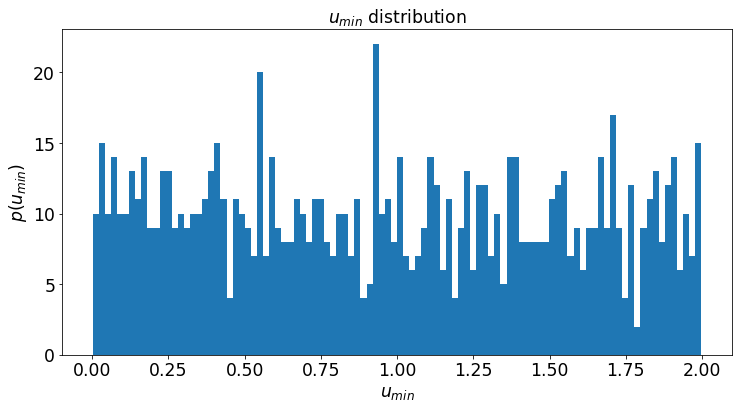

In [11]:
N = 1000
uminmin = 0
uminmax = 2
umin = uniform.rvs(uminmin,uminmax,N)

plt.hist(umin,bins=100)
plt.xlabel("$u_{min}$")
plt.ylabel("$p(u_{min})$")
plt.title("$u_{min}$ distribution")

# Define LMC coordinates

In [12]:
import astroquery
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad

In [13]:
result_table = Simbad.query_object("lmc")

In [14]:
galaxy_coord = SkyCoord(ra=result_table["RA"][0]+"hour",dec=result_table["DEC"][0]+ "degrees")
galaxy_ra = galaxy_coord.ra.deg
galaxy_dec = galaxy_coord.dec.deg
print(galaxy_ra,galaxy_dec)

80.89416666666666 -69.75611111111111


### 

 - We only keep data points in a 3.5° field around the center of the LMC

In [15]:
from photutils.aperture import SkyCircularAperture
from regions import CircleSkyRegion

positions = SkyCoord(galaxy_ra, galaxy_dec, unit = 'deg').galactic
aper = SkyCircularAperture(positions, 3.5/2 * u.deg)
Circle = CircleSkyRegion(positions, 3.5/2 * u.deg)

In [16]:
data_coords = []
data_coords_u = []
data_coords_g = []
data_coords_r = []
data_coords_i = []
data_coords_z = []
data_coords_y = []
gal_u = []
gal_g = []
gal_r = []
gal_i = []
gal_z = []
gal_y = []

for i in range (len(df['observationStartMJD'])) :
    
    data_coords.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
    
    if (df["filter"][i] == "u") :
        
        data_coords_u.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
        gal_u.append(data_coords[i].galactic)
   
    elif (df["filter"][i] == "g") :
        
        data_coords_g.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
        gal_g.append(data_coords[i].galactic)
        
    elif (df["filter"][i] == "r") :
        
        data_coords_r.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
        gal_r.append(data_coords[i].galactic)
        
    elif (df["filter"][i] == "i") :
        
        data_coords_i.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
        gal_i.append(data_coords[i].galactic)
           
    elif (df["filter"][i] == "z") :
        
        data_coords_z.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
        gal_z.append(data_coords[i].galactic)
        
    elif (df["filter"][i] == "y") :
        
        data_coords_y.append(SkyCoord(ra = df['fieldRA'].values[i], dec = df['fieldDec'].values[i], unit = 'deg'))
        gal_y.append(data_coords[i].galactic)
        

# Sky map of the data points in galactic coordinates 

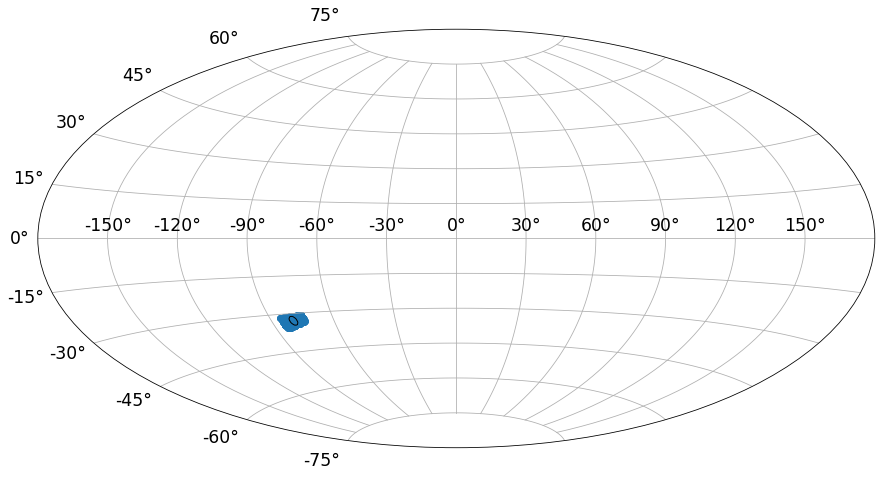

In [17]:
Circle_1 = plt.Circle((positions.l.wrap_at('180d').radian, positions.b.radian), 3.5*np.pi/180/2, fill = False)
gal = SkyCoord(df['fieldRA'], df['fieldDec'], unit='deg').galactic
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(projection='aitoff')
ax.add_patch(Circle_1)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian, color='C0', alpha=1, marker='o')
plt.grid();

# Sky map of the data points in galactic coordinates (with colors for each filter)

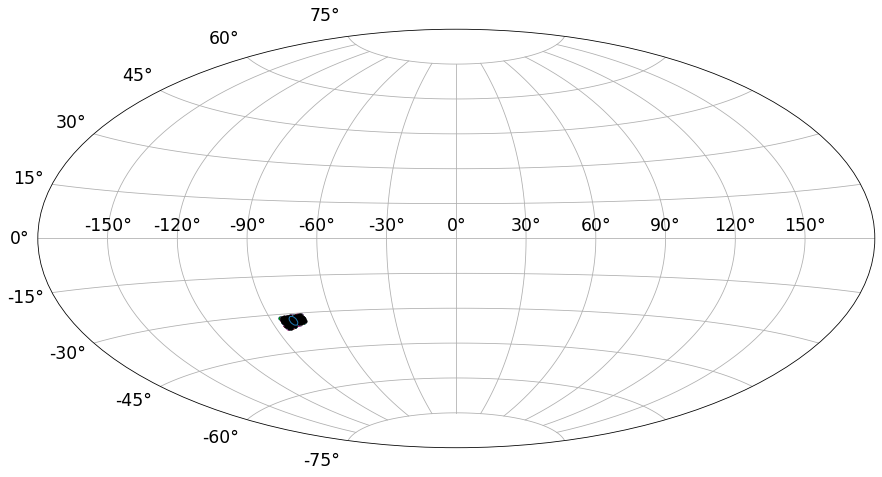

In [18]:
fig = plt.figure(figsize=(15, 10))
Circle_1 = plt.Circle((positions.l.wrap_at('180d').radian, positions.b.radian), 3.5*np.pi/180/2, fill = False, color ='C0')
ax = plt.subplot(projection='aitoff')
ax.add_patch(Circle_1)

for i in range (len(gal_u)) :

    plt.scatter(gal_u[i].l.wrap_at('180d').radian, gal_u[i].b.radian, color ='b', alpha=1, marker='.')
    
for i in range (len(gal_g)) :
    
    plt.scatter(gal_g[i].l.wrap_at('180d').radian, gal_g[i].b.radian, color = "g", alpha=1, marker='.')
    
for i in range (len(gal_r)) :
    
    plt.scatter(gal_r[i].l.wrap_at('180d').radian, gal_r[i].b.radian, color = "r", alpha=1, marker='.')
    
for i in range (len(gal_i)) :
    
    plt.scatter(gal_i[i].l.wrap_at('180d').radian, gal_i[i].b.radian, color = "blueviolet", alpha=1, marker='.')
    
for i in range (len(gal_z)) :
    
    plt.scatter(gal_z[i].l.wrap_at('180d').radian, gal_z[i].b.radian, color = "grey", alpha=1, marker='.')
    
for i in range (len(gal_y)) :
    
    plt.scatter(gal_y[i].l.wrap_at('180d').radian, gal_y[i].b.radian, color = "k", alpha=1, marker='.')

plt.grid();

In [19]:
from astropy.wcs import WCS

In [20]:
File = fits.open(r'D:\Projet de recherche\Stage\skv20135441655710.fits')

image = File[0].data
header = File[0].header
wcs = WCS(header)

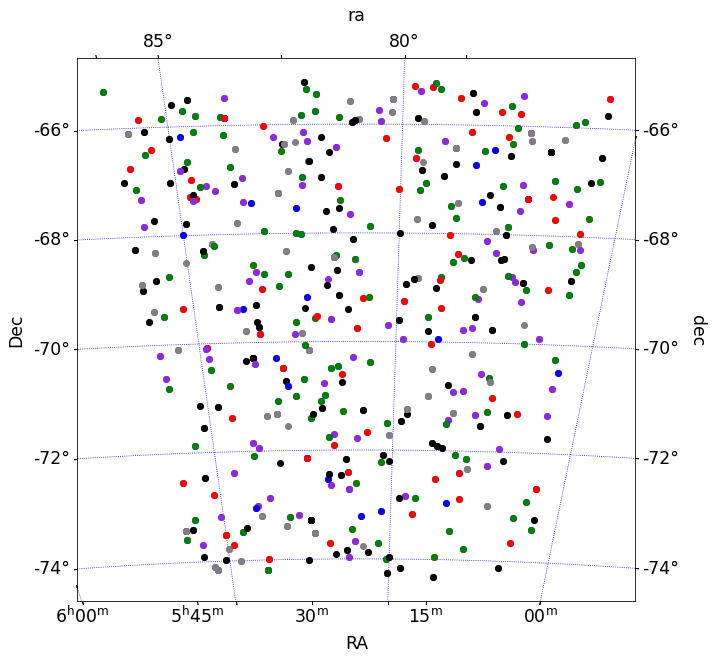

In [21]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection = wcs)
#plt.imshow(image, origin='lower', cmap='cividis', aspect='equal')
#Circle_2 = plt.Circle((galaxy_ra, galaxy_dec), 3.5, fill = False, color ='C0')
#ax.add_patch(Circle_2)

for i in range (len(df['observationId'])) :

    if (df['filter'][i] == "u") :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='b', marker='o')
        
    if (df['filter'][i] == "g") :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='g', marker='o')
        
    if (df['filter'][i] == "r") :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='r', marker='o')
        
    if (df['filter'][i] == "i") :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='blueviolet', marker='o')
        
    if (df['filter'][i] == "z") :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='grey', marker='o')
        
    if (df['filter'][i] == "y") :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='k', marker='o')
    
#ax.plot_coord(SkyCoord(galaxy_ra * u.deg, galaxy_dec * u.deg), marker = 'o')   
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='blue', ls='dotted')

In [22]:
df_test = df[((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]

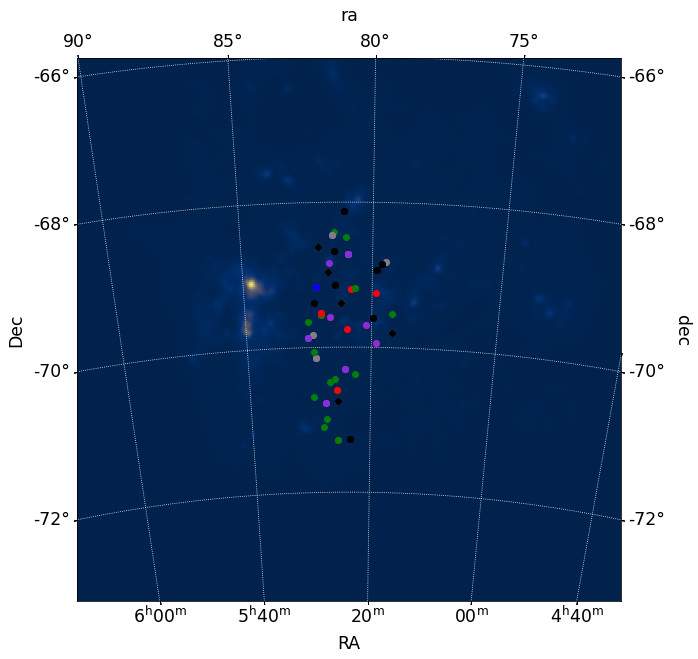

In [23]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection = wcs)
plt.imshow(image, origin='lower', cmap='cividis', aspect='equal')   
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')


for i in range (len(df['observationId'])) :

    if (df['filter'][i] == 'u' and (df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='b', marker='o')
        
    if (df['filter'][i] == 'g' and (df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='g', marker='o')
        
    if (df['filter'][i] == 'r' and (df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='r', marker='o')
        
    if (df['filter'][i] == 'i' and (df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value*2**2) :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='blueviolet', marker='o')
        
    if (df['filter'][i] == 'z' and (df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='grey', marker='o')
        
    if (df['filter'][i] == 'y' and (df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='k', marker='o')
        
# 7.5° image

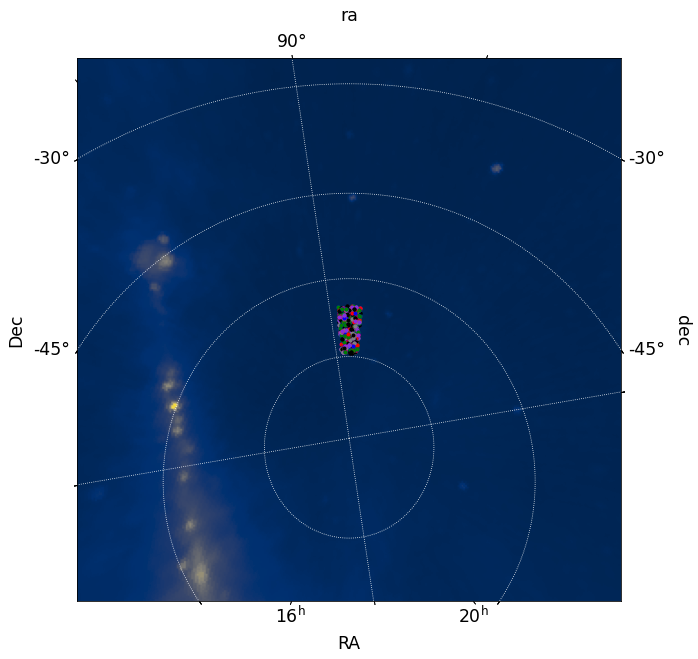

In [24]:
File_big = fits.open(r'D:\Projet de recherche\Stage\skv20134946561546.fits')

image_big = File_big[0].data
header_big = File_big[0].header
wcs_big = WCS(header_big)

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection = wcs_big)
plt.imshow(image_big, origin='lower', cmap='cividis', aspect='equal')   
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')


for i in range (len(df['observationId'])) :

    if (df['filter'][i] == 'u' ):
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='b', marker='.')
        
    if (df['filter'][i] == 'g'  ):
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='g', marker='.')
        
    if (df['filter'][i] == 'r'  ):
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='r', marker='.')
        
    if (df['filter'][i] == 'i'  ):
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='blueviolet', marker='.')
        
    if (df['filter'][i] == 'z' ) :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='grey', marker='.')
        
    if (df['filter'][i] == 'y')  :
        
        ax.plot_coord(SkyCoord(df['fieldRA'][i] * u.deg, df['fieldDec'][i] * u.deg), color ='k', marker='.')

# Plot of the data points coordinates (RA, Dec) and the LSST field of view ( 3.5° circle around the center of the LMC)

Text(0, 0.5, 'Declination')

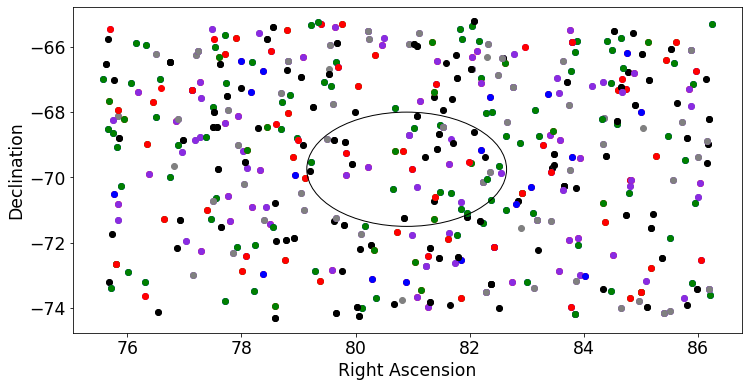

In [25]:
Circle_3 = plt.Circle((galaxy_ra, galaxy_dec), 3.5/2, fill = False)
fig, ax = plt.subplots() 

for i in range (len(df['observationStartMJD'])) :
    
    if (df["filter"][i] == "u") :
        
        plt.scatter(df["fieldRA"][i], df['fieldDec'][i], color = 'b', marker = 'o')
   
    elif (df["filter"][i] == "g") :
        
        plt.scatter(df["fieldRA"][i], df['fieldDec'][i], color = 'g', marker = 'o')
        
    elif (df["filter"][i] == "r") :
        
        plt.scatter(df["fieldRA"][i], df['fieldDec'][i], color = 'r', marker = 'o')
        
    elif (df["filter"][i] == "i") :
        
        plt.scatter(df["fieldRA"][i], df['fieldDec'][i], color = 'blueviolet', marker = 'o')
           
    elif (df["filter"][i] == "z") :
        
        plt.scatter(df["fieldRA"][i], df['fieldDec'][i], color = 'grey', marker = 'o')
        
    elif (df["filter"][i] == "y") :
        
        plt.scatter(df["fieldRA"][i], df['fieldDec'][i], color = 'k', marker = 'o')
        


ax.add_patch(Circle_3)
plt.xlabel("Right Ascension")
plt.ylabel("Declination")

# We only keep the data points inside the LSST field of view  

Text(0, 0.5, 'Declination')

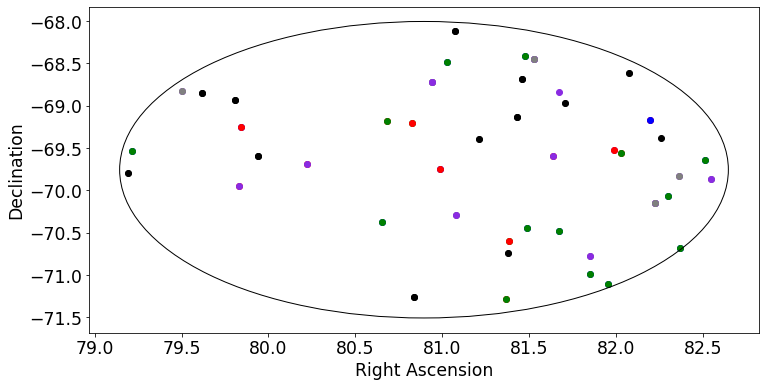

In [26]:
Circle_3 = plt.Circle((galaxy_ra, galaxy_dec), 3.5/2, fill = False)
fig, ax = plt.subplots() 

for i in range (len(df_test['observationStartMJD'])) :
    
    if (df_test["filter"].values[i] == "u") :
        
        plt.scatter(df_test["fieldRA"].values[i], df_test['fieldDec'].values[i], color = 'b', marker = 'o')
   
    elif (df_test["filter"].values[i] == "g") :
        
        plt.scatter(df_test["fieldRA"].values[i], df_test['fieldDec'].values[i], color = 'g', marker = 'o')
        
    elif (df_test["filter"].values[i] == "r") :
        
        plt.scatter(df_test["fieldRA"].values[i], df_test['fieldDec'].values[i], color = 'r', marker = 'o')
        
    elif (df_test["filter"].values[i] == "i") :
        
        plt.scatter(df_test["fieldRA"].values[i], df_test['fieldDec'].values[i], color = 'blueviolet', marker = 'o')
           
    elif (df_test["filter"].values[i] == "z") :
        
        plt.scatter(df_test["fieldRA"].values[i], df_test['fieldDec'].values[i], color = 'grey', marker = 'o')
        
    elif (df_test["filter"].values[i] == "y") :
        
        plt.scatter(df_test["fieldRA"].values[i], df_test['fieldDec'].values[i], color = 'k', marker = 'o')
        
ax.add_patch(Circle_3)
plt.xlabel("Right Ascension")
plt.ylabel("Declination")

# Relative angular source-lens separation u(t)

$$ 
   u(t) = \sqrt{u_{0}^2 + (\frac{t-t_0}{t_E})^2)}
$$




In [27]:
def u(t):
    return np.sqrt(u0**2+ ((t-t0)/tE)**2)

# Amplitude as a function of u(t)

$$
    A(u) = \frac{u^2 + 2}{u\sqrt{u^2 + 4}}
$$

In [28]:
def A(u):
    return (u**2+2)/u/np.sqrt(u**2+4)

# Amplitude as a function of u0, t0, tE

$$
    A(t, u_0, t_0, t_E) = \frac{u_{0}^2 + (\frac{t-t_0}{t_E})^2) + 2}{\sqrt{u_{0}^2 + (\frac{t-t_0}{t_E})^2)} \sqrt{u_{0}^2 + (\frac{t-t_0}{t_E})^2) + 4}}
$$

In [29]:
def Ab(t, u0, t0, tE) :
    return ((np.sqrt(u0**2+ ((t-t0)/tE)**2))**2+2)/(np.sqrt(u0**2+ ((t-t0)/tE)**2))/np.sqrt((np.sqrt(u0**2+ ((t-t0)/tE)**2))**2+4) 

# Gaussian

$$
    y = \frac{A}{\sigma \sqrt{2\pi}} e^{\frac{-(x - \mu)^2}{2\sigma^2}}
$$

In [30]:
#Gaussian fit

def Gauss(x, A, mu ,sigma) :
    return A*np.exp(-(x-mu)**2/(2*sigma**2))/sigma/np.sqrt(2*np.pi)

# Linear 

$$
    y = \alpha x + \beta
$$


In [31]:
#Linear fit

def linear(x, alpha, beta) : 
    return alpha*x + beta

# Plotting the light curve and Microlensing fit with arbitrary errors

t0 = 62319.94703589089
tE = 20
u0 = 1.9917118908288078


(62219.94703589089, 62419.94703589089)

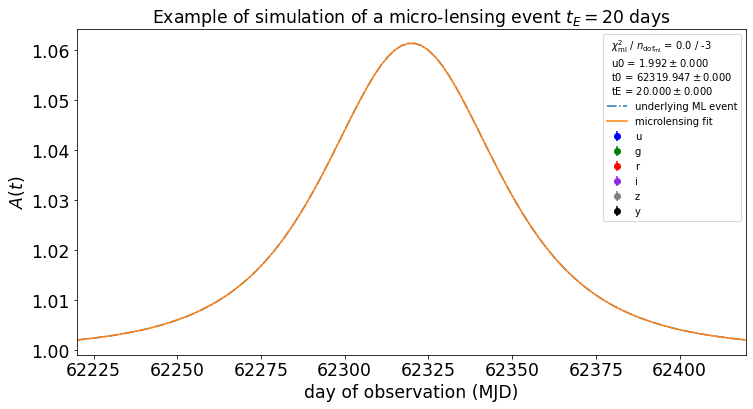

In [32]:
#Randomize parameters

from random import *

u0 = umin[randrange(len(umin))]
t0 = list_t0[randrange(len(list_t0))] 

#tE distribution or value

tE = 20

#Time t 

tmin=t0-5.*tE
tmax=t0+5.*tE
ti=np.linspace(tmin,tmax,100)


print("t0 = {}".format(t0)) #Display values
print("tE = {}".format(tE))
print("u0 = {}".format(u0))



#We distinguish data points by filter

df_event_u = df[(df["filter"] == "u") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 
df_event_g = df[(df["filter"] == "g") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 
df_event_r = df[(df["filter"] == "r") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 
df_event_i = df[(df["filter"] == "i") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)]  
df_event_z = df[(df["filter"] == "z") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)]  
df_event_y = df[(df["filter"] == "y") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 
df_event = df[(df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax)] 

df_event_times = df_event["observationStartMJD"].values
df_event_times_u = df_event_u["observationStartMJD"].values 
df_event_times_g = df_event_g["observationStartMJD"].values
df_event_times_r = df_event_r["observationStartMJD"].values
df_event_times_i = df_event_i["observationStartMJD"].values
df_event_times_z = df_event_z["observationStartMJD"].values
df_event_times_y = df_event_y["observationStartMJD"].values


#Plot

plt.plot(ti,A(u(ti)),"-.",label="underlying ML event")
#plt.scatter(df_event_times,A(u(df_event_times)),marker="o",s=20,color = "b",label="u")
#plt.scatter(df_event_u_times,A(u(df_event_u_times)),marker="o",s=20,color = "b",label="u")
#plt.scatter(df_event_g_times,A(u(df_event_g_times)),marker="o",s=20,color = "g",label="g")
#plt.scatter(df_event_r_times,A(u(df_event_r_times)),marker="o",s=20,color = "r",label="r")
#plt.scatter(df_event_i_times,A(u(df_event_i_times)),marker="o",s=20,color ="blueviolet",label="i")
#plt.scatter(df_event_z_times,A(u(df_event_z_times)),marker="o",s=20,color ="grey",label="z")
#plt.scatter(df_event_y_times,A(u(df_event_y_times)),marker="o",s=20,color="k",label="y")

# Microlensing fit with iMinuit

x = df_event_times       
x_u = df_event_times_u
x_g = df_event_times_g
x_r = df_event_times_r
x_i = df_event_times_i
x_z = df_event_times_z
x_y = df_event_times_y

y_data = A(u(df_event_times))

y_noise = 0.01

y = y_data + y_noise * np.random.randn(len(x))
y_u = A(u(df_event_times_u)) + y_noise * np.random.randn(len(x_u))
y_g = A(u(df_event_times_g)) + y_noise * np.random.randn(len(x_g))
y_r = A(u(df_event_times_r)) + y_noise * np.random.randn(len(x_r))
y_i = A(u(df_event_times_i)) + y_noise * np.random.randn(len(x_i)) 
y_z = A(u(df_event_times_z)) + y_noise * np.random.randn(len(x_z))
y_y = A(u(df_event_times_y)) + y_noise * np.random.randn(len(x_y))


plt.errorbar(x_u, y_u, y_noise, fmt="o", label="u", color = "b")  #Show data points with their respective photometric error
plt.errorbar(x_g, y_g, y_noise, fmt="o", label="g", color = "g")  #Color depends on the filter
plt.errorbar(x_r, y_r, y_noise, fmt="o", label="r", color = "r")
plt.errorbar(x_i, y_i, y_noise, fmt="o", label="i", color = "blueviolet")
plt.errorbar(x_z, y_z, y_noise, fmt="o", label="z", color ="grey")
plt.errorbar(x_y, y_y, y_noise, fmt="o", label="y", color ="k")

least_squares = LeastSquares(x, y, y_noise, Ab)        # Fit using the least squares method
m = Minuit(least_squares, u0 = u0, t0 = t0, tE = tE)  #starting values for our parameters


m.migrad() # finds minimum of least_squares function
m.hesse()  # accurately computes uncertainties

plt.plot(ti, Ab(ti, *m.values), label="microlensing fit") 


#Plot legend etc

fit_info = [
    f"$\\chi^2_\\mathrm{{ml}}$ / $n_\\mathrm{{dof_\\mathrm{{ml}}}}$ = {m.fval:.1f} / {len(x) - m.nfit}",    #Display fit info  
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.xlabel("day of observation (MJD)")
plt.ylabel("$A(t)$")
plt.title("Example of simulation of a micro-lensing event $t_E = 20$ days")
plt.legend(title="\n".join(fit_info))
plt.xlim(tmin,tmax)

# Linear fit

(62219.94703589089, 62419.94703589089)

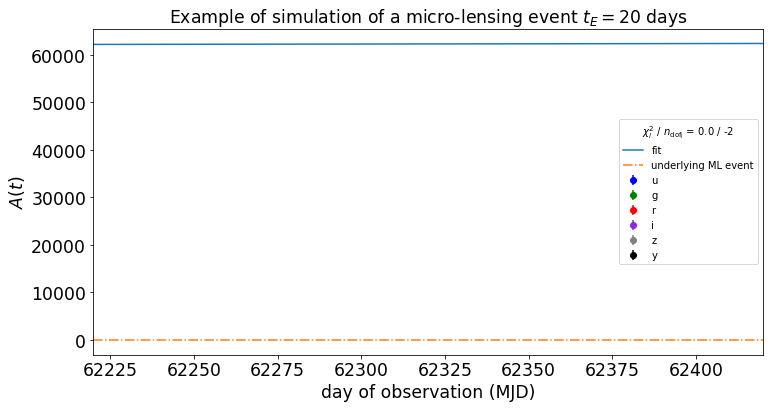

In [33]:
least_squares_line = LeastSquares(x, y, y_noise, linear) #linear least squares
m_line = Minuit(least_squares_line, alpha=1, beta=1)  

m_line.migrad() # finds minimum of least_squares function
m_line.hesse()  # accurately computes uncertainties

plt.errorbar(x_u, y_u, y_noise, fmt="o", label="u", color = "b")  #Show data points with their respective photometric error
plt.errorbar(x_g, y_g, y_noise, fmt="o", label="g", color = "g")  #Color depends on the filter
plt.errorbar(x_r, y_r, y_noise, fmt="o", label="r", color = "r")
plt.errorbar(x_i, y_i, y_noise, fmt="o", label="i", color = "blueviolet")
plt.errorbar(x_z, y_z, y_noise, fmt="o", label="z", color ="grey")
plt.errorbar(x_y, y_y, y_noise, fmt="o", label="y", color ="k")
plt.plot(ti, linear(ti, *m_line.values), label="fit")
plt.plot(ti,A(u(ti)),"-.",label="underlying ML event")


fit_info = [
    f"$\\chi^2_l$ / $n_\\mathrm{{dof_l}}$ = {m_line.fval:.1f} / {len(x) - m_line.nfit}",     #Display fit info
]
plt.xlabel("day of observation (MJD)")
plt.ylabel("$A(t)$")
plt.title("Example of simulation of a micro-lensing event $t_E = 20$ days")
plt.legend(title="\n".join(fit_info))
plt.xlim(tmin,tmax)

In [34]:
(m_line.fval - m.fval)/np.sqrt(2*(len(x)- m.nfit)) 

<ipython-input-34-7484acbd7f07>:1: RuntimeWarning: invalid value encountered in sqrt
  (m_line.fval - m.fval)/np.sqrt(2*(len(x)- m.nfit))


nan

# Test error on magnitude

In [35]:

m = 20
xerr = []
sigma_sys = 0.003
error_photo = []


for i in range (len(df)) :
    
    xerr.append( 10**(0.4*(m - df["fiveSigmaDepth"][i])))
    
    if (df["filter"][i] == "u") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.037) * xerr[i] + 0.037 * xerr[i]**2))  
   
    elif (df["filter"][i] == "g") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.038) * xerr[i] + 0.038 * xerr[i]**2))  
        
    elif (df["filter"][i] == "r") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.039) * xerr[i] + 0.039 * xerr[i]**2))  
        
    elif (df["filter"][i] == "i") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.039) * xerr[i] + 0.039 * xerr[i]**2))      
           
    elif (df["filter"][i] == "z") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.040) * xerr[i] + 0.040 * xerr[i]**2))     
        
    elif (df["filter"][i] == "y") :
        
        error_photo.append( np.sqrt(sigma_sys**2 + (0.04 - 0.040) * xerr[i] + 0.040 * xerr[i]**2))
        


# Photo error as a function of magnitude

Text(0.5, 1.0, 'Photometric error as a function of magnitude')

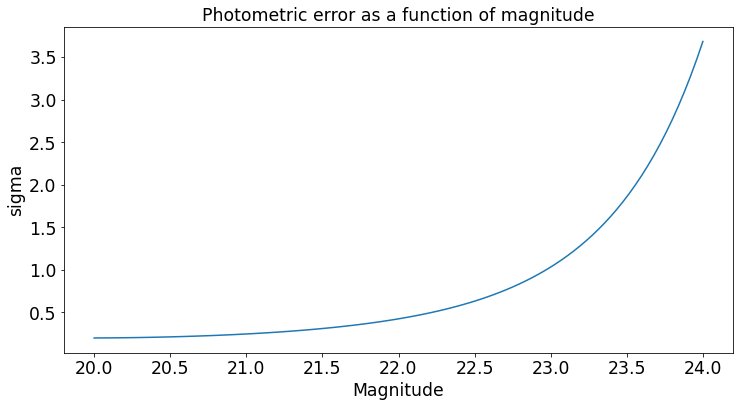

In [36]:
mag = np.linspace(20,24,100)
sigma = []

for i in range (len(mag)) :
    
    sigma.append(np.sqrt(sigma_sys**2 + (0.04 - 0.037) * 10**(0.4*(mag[i] - 20)) + 0.037 * 10**(0.4*(mag[i] - 20))**2))

    
plt.plot(mag,sigma)
plt.xlabel("Magnitude")
plt.ylabel("sigma")
plt.title("Photometric error as a function of magnitude")
#plt.text(x = 21, y = 3, s = "Low magnitude/Bright source means high photometric error", fontsize = 15, color = 'r')

# Background noise

$$
    F_b = F_{ab}10^{-0.4m_b} \times \pi \theta_{seeing}^2 
$$

$$
     F_{ab} = 3631 Jy = 3631\times10^{-23} erg.s^{-1}.Hz^{-1}.cm^{-2} = 3631\times10^{-26} W.Hz^{-1}.m^{-2}
$$

$$
    N_{pe}^b = \frac{\pi D^2 \Delta T}{4h}F_b \int_{}^{} T^{syst}_b(\lambda) \,\frac{d\lambda}{\lambda} 
$$

In [37]:
df_LSST = pd.read_csv("D:\\Projet de recherche\Stage\lsst_throughput.csv", index_col=0)

In [38]:
LSST_u = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["u"].values, name = "u")
LSST_g = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["g"].values, name = "g")
LSST_r = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["r"].values, name = "r")
LSST_i = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["i"].values, name = "i")
LSST_z = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["z"].values, name = "z")
LSST_y = S.ArrayBandpass(df_LSST["wl"].values*10, df_LSST["y"].values, name = "y")

Wave = df_LSST["wl"]*10
Wavelength = np.array(Wave)

In [39]:
ObservationStartMJD_u = []
ObservationStartMJD_g = []
ObservationStartMJD_r = []
ObservationStartMJD_i = []
ObservationStartMJD_z = []
ObservationStartMJD_y = []

for i in range (len(df["observationId"])) :
    
    if (df['filter'][i] == 'u') :
            
            ObservationStartMJD_u.append(df["observationStartMJD"].values[i])
    
    if (df['filter'][i] == 'g') :
            
            ObservationStartMJD_g.append(df["observationStartMJD"].values[i])
            
    if (df['filter'][i] == 'r') :
            
            ObservationStartMJD_r.append(df["observationStartMJD"].values[i])
            
    if (df['filter'][i] == 'i') :
            
            ObservationStartMJD_i.append(df["observationStartMJD"].values[i])
            
    if (df['filter'][i] == 'z') :
            
            ObservationStartMJD_z.append(df["observationStartMJD"].values[i])
            
    if (df['filter'][i] == 'y') :
        
            ObservationStartMJD_y.append(df["observationStartMJD"].values[i])

In [40]:
from astropy import units as u

D = Deff
Delta_T = EXPOSURE
F_ab = 3631*10**(-23) * u.erg/u.s/u.Hz/u.cm**2

In [41]:
F_ab.to(u.jansky)

<Quantity 3631. Jy>

In [42]:
H = S.units.H * (u.erg * u.s)
H

<Quantity 6.6262e-27 erg s>

In [43]:
F_b = []
F_b_u = []
F_b_g = []
F_b_r = []
F_b_i = []
F_b_z = []
F_b_y = []

for i in range (len(df["observationId"])) :
    
    F_b.append(F_ab * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))
    
    if (df['filter'][i] == 'u') :
            
            F_b_u.append(F_ab.value * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))
    
    if (df['filter'][i] == 'g') :
            
            F_b_g.append(F_ab.value * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))
            
    if (df['filter'][i] == 'r') :
            
            F_b_r.append(F_ab.value * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))
            
    if (df['filter'][i] == 'i') :
            
            F_b_i.append(F_ab.value * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))
            
    if (df['filter'][i] == 'z') :
            
            F_b_z.append(F_ab.value * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))
            
    if (df['filter'][i] == 'y') :
        
            F_b_y.append(F_ab.value * pow(10,-0.4*df["skyBrightness"][i]) * np.pi * pow(df["seeingFwhmEff"][i],2))

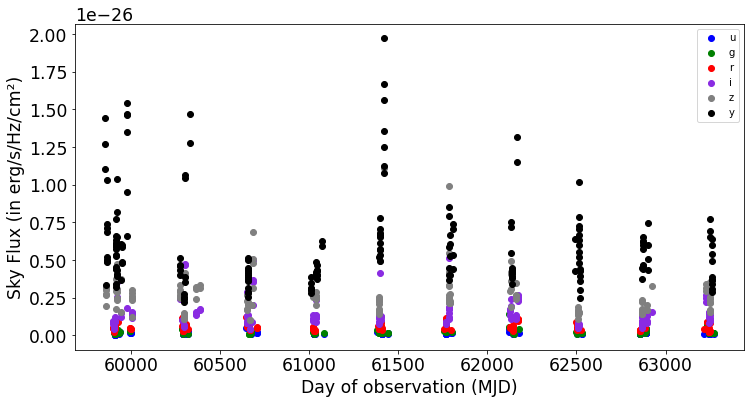

In [44]:
plt.scatter(ObservationStartMJD_u, F_b_u, color = 'b', label = 'u')
plt.scatter(ObservationStartMJD_g, F_b_g, color = 'g', label = 'g')
plt.scatter(ObservationStartMJD_r, F_b_r, color = 'r', label = 'r')
plt.scatter(ObservationStartMJD_i, F_b_i, color = 'blueviolet', label = 'i')
plt.scatter(ObservationStartMJD_z, F_b_z, color = 'grey', label = 'z')
plt.scatter(ObservationStartMJD_y, F_b_y, color = 'k', label = 'y')
plt.ylabel("Sky Flux (in erg/s/Hz/cm²)")
plt.xlabel("Day of observation (MJD)")
plt.legend()

In [45]:
N_pe = []
N_pe_u = []
N_pe_g = []
N_pe_r = []
N_pe_i = []
N_pe_z = []
N_pe_y = []

for i in range (len(F_b)) :
    
    if (df['filter'][i] == 'u') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i].value/(4*S.units.H)*integrate.trapz(LSST_u.throughput/Wavelength))
            N_pe_u.append(N_pe[i])
    
    if (df['filter'][i] == 'g') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i].value/(4*S.units.H)*integrate.trapz(LSST_g.throughput/Wavelength))
            N_pe_g.append(N_pe[i])
            
    if (df['filter'][i] == 'r') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i].value/(4*S.units.H)*integrate.trapz(LSST_r.throughput/Wavelength))
            N_pe_r.append(N_pe[i])
            
    if (df['filter'][i] == 'i') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i].value/(4*S.units.H)*integrate.trapz(LSST_i.throughput/Wavelength))
            N_pe_i.append(N_pe[i])
            
    if (df['filter'][i] == 'z') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i].value/(4*S.units.H)*integrate.trapz(LSST_z.throughput/Wavelength))
            N_pe_z.append(N_pe[i])
            
    if (df['filter'][i] == 'y') :
            
            N_pe.append(np.pi*D**2*Delta_T*F_b[i].value/(4*S.units.H)*integrate.trapz(LSST_y.throughput/Wavelength))
            N_pe_y.append(N_pe[i])


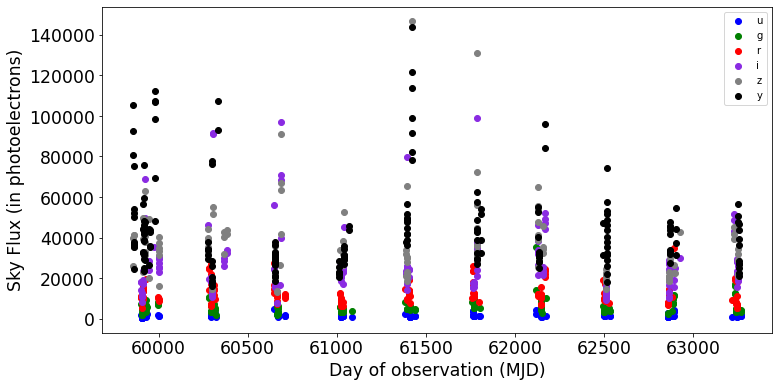

In [46]:
plt.scatter(ObservationStartMJD_u, N_pe_u, color = 'b', label = 'u')
plt.scatter(ObservationStartMJD_g, N_pe_g, color = 'g', label = 'g')
plt.scatter(ObservationStartMJD_r, N_pe_r, color = 'r', label = 'r')
plt.scatter(ObservationStartMJD_i, N_pe_i, color = 'blueviolet', label = 'i')
plt.scatter(ObservationStartMJD_z, N_pe_z, color = 'grey', label = 'z')
plt.scatter(ObservationStartMJD_y, N_pe_y, color = 'k', label = 'y')
plt.ylabel("Sky Flux (in photoelectrons)")
plt.xlabel("Day of observation (MJD)")
plt.legend()

In [47]:
integrate.trapz(LSST_u.throughput/Wavelength)

0.006519157490141833

In [48]:
a = 0

for i in range (len(LSST_u.throughput)) :
    
    a = a + LSST_u.throughput[i]/Wavelength[i]
    
a

0.006519276406808502

In [49]:
agk_81d266 = os.path.join(os.environ['PYSYN_CDBS'], 'calspec', 'agk_81d266_stisnic_007.fits')

agk_81d266_spec = S.FileSpectrum(agk_81d266).renorm(20, 'abmag', S.ObsBandpass('johnson,v'))

agk_81d266_spec.convert('count')

(0.0, 6000.0)

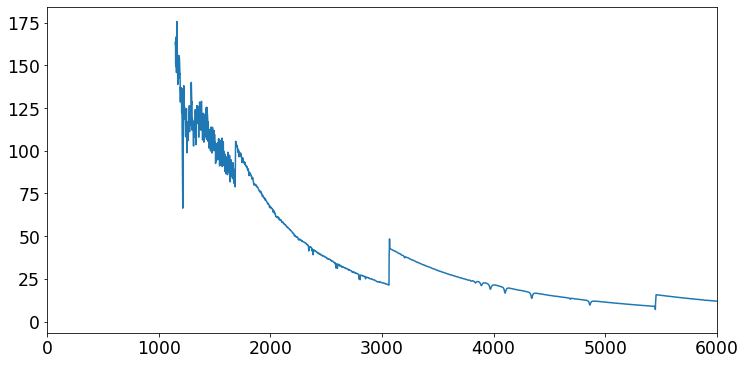

In [50]:
plt.plot(agk_81d266_spec.wave, agk_81d266_spec.flux)
plt.xlim([0,6000])

# Atmospheric throughput for every observation

In [52]:
df_LMC_atmo = pd.read_csv(r'D:\Projet de recherche\Stage\Baseline_LMCv1_Atmosphere.csv')
df_LMC_atmo

,1,2,3,4,5,6,7,8,9,10,...,887,888,889,890,891,892,893,894,895,896
3000,0.009290,0.007645,0.006239,0.005402,0.009404,0.005323,0.007454,0.009175,0.007973,0.006507,...,0.005234,0.006587,0.008061,0.009584,0.005245,0.008040,0.005131,0.007894,0.008138,0.007270
3010,0.014854,0.012475,0.010382,0.009125,0.015018,0.009006,0.012198,0.014687,0.012949,0.010785,...,0.008873,0.010905,0.013077,0.015279,0.008890,0.013047,0.008718,0.012834,0.013187,0.011931
3020,0.021952,0.018749,0.015862,0.014115,0.022173,0.013950,0.018377,0.021728,0.019387,0.016422,...,0.013765,0.016589,0.019560,0.022525,0.013788,0.019519,0.013550,0.019233,0.019708,0.018014
3030,0.035094,0.030581,0.026392,0.023836,0.035406,0.023594,0.030057,0.034779,0.031481,0.027211,...,0.023323,0.027456,0.031724,0.035901,0.023357,0.031666,0.023009,0.031264,0.031933,0.029543
3040,0.041745,0.036646,0.031861,0.028932,0.042097,0.028655,0.036054,0.041389,0.037662,0.032800,...,0.028344,0.033080,0.037937,0.042657,0.028384,0.037872,0.027985,0.037417,0.038173,0.035471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11960,0.972714,0.971665,0.970460,0.969685,0.972787,0.969611,0.971543,0.972641,0.971874,0.970709,...,0.969529,0.970783,0.971931,0.972902,0.969539,0.971917,0.969434,0.971824,0.971979,0.971416
11970,0.972714,0.971665,0.970460,0.969685,0.972787,0.969611,0.971543,0.972641,0.971874,0.970709,...,0.969529,0.970783,0.971931,0.972902,0.969539,0.971917,0.969434,0.971824,0.971979,0.971416
11980,0.955584,0.953960,0.952106,0.950914,0.955696,0.950801,0.953771,0.955470,0.954283,0.952488,...,0.950675,0.952602,0.954371,0.955874,0.950691,0.954350,0.950529,0.954205,0.954446,0.953575
11990,0.955584,0.953960,0.952106,0.950914,0.955696,0.950801,0.953771,0.955470,0.954283,0.952488,...,0.950675,0.952602,0.954371,0.955874,0.950691,0.954350,0.950529,0.954205,0.954446,0.953575


In [53]:
bp_atmo = []

for i in range (len(df['observationId'])) :
    
    #if (df["observationStartMJD"].values[i] >= tmin) & (df["observationStartMJD"].values[i] <= tmax) :
        
    bp = S.ArrayBandpass(df_LSST["wl"].values*10, df_LMC_atmo.iloc[:,i].values, name = "Observation " + str(i+1))
    bp_atmo.append(bp)

In [54]:
all_bp = []
all_bp_u = []
all_bp_g = []
all_bp_r = []
all_bp_i = []
all_bp_z = []
all_bp_y = []

for i in range (len(bp_atmo)) :

    if (df['filter'][i] == 'u') :
        
        bp = LSST_u * bp_atmo[i]
        all_bp.append(bp)
        all_bp_u.append(bp)
        
    elif (df['filter'][i] == 'g') :
        
        bp = LSST_g * bp_atmo[i]
        all_bp.append(bp)
        all_bp_g.append(bp)
    
    elif (df['filter'][i] == 'r') :
        
        bp = LSST_r * bp_atmo[i]
        all_bp.append(bp)
        all_bp_r.append(bp)
    
    elif (df['filter'][i] == 'i') :
        
        bp = LSST_i * bp_atmo[i]
        all_bp.append(bp)
        all_bp_i.append(bp)
    
    elif (df['filter'][i] == 'z') :
        
        bp = LSST_z * bp_atmo[i]
        all_bp.append(bp)
        all_bp_z.append(bp)
    
    elif (df['filter'][i] == 'y') :
        
        bp = LSST_y * bp_atmo[i]
        all_bp.append(bp)
        all_bp_y.append(bp)

# Define the source spectrum below

In [55]:
Spec = S.Vega.renorm(20, 'abmag', S.ObsBandpass('johnson,v'))

In [56]:
all_obs = []

for bp in all_bp :
    
    obs = S.Observation(Spec, bp);
    all_obs.append(obs);

((y * Observation 1)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 2)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 3)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 6)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.


((i * Observation 89)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 90)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 91)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 92)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 93)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 94)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 95)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 96)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((g * Observation 183)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 184)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 185)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 186)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 187)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 188)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 189)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 190)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((y * Observation 277)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 278)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 279)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 280)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 281)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 282)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 283)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 284)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((g * Observation 370)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 371)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 372)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 373)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 374)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 375)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 376)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 377)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((g * Observation 465)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 466)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 467)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 468)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 469)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 470)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 471)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 472)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((y * Observation 561)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 562)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 563)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 564)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 565)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 566)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 567)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 568)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((u * Observation 657)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 658)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 659)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 660)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 661)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 662)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 663)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 664)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((r * Observation 750)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 751)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 752)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 753)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 754)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 755)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 756)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 757)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((r * Observation 846)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 847)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 848)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 849)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 850)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 851)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 852)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 853)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

In [57]:
all_obs_u = []
all_obs_g = []
all_obs_r = []
all_obs_i = []
all_obs_z = []
all_obs_y = []

for bp in all_bp_u :
    
    obs_u = S.Observation(Spec, bp);
    all_obs_u.append(obs_u);
    
for bp in all_bp_g :
    
    obs_g = S.Observation(Spec, bp);
    all_obs_g.append(obs_g);
    
for bp in all_bp_r :
    
    obs_r = S.Observation(Spec, bp);
    all_obs_r.append(obs_r);
    
for bp in all_bp_i :
    
    obs_i = S.Observation(Spec, bp);
    all_obs_i.append(obs_i);
    
for bp in all_bp_z :
    
    obs_z = S.Observation(Spec, bp);
    all_obs_z.append(obs_z);
    
for bp in all_bp_y :
    
    obs_y = S.Observation(Spec, bp);
    all_obs_y.append(obs_y);

((u * Observation 25)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 39)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 40)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 41)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 42)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 43)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 101)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 103)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used

((u * Observation 676)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 677)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 678)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 679)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 721)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 722)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 725)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((u * Observation 726)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((g * Observation 371)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 372)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 373)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 403)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 405)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 427)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 428)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((g * Observation 429)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((r * Observation 38)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 53)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 54)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 55)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 56)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 57)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 58)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 59)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((r * Observation 644)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 653)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 668)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 669)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 670)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 671)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 672)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((r * Observation 673)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((i * Observation 332)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 342)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 343)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 344)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 345)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 381)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 382)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 383)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((i * Observation 870)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 871)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 872)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((i * Observation 874)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 4)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 5)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 7)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 8)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used i

((z * Observation 550)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 551)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 552)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 555)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 556)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 557)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 558)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((z * Observation 581)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((y * Observation 118)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 119)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 120)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 122)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 123)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 124)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 125)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 126)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

((y * Observation 596)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 597)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 598)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 599)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 600)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 601)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 602)) does not have a defined binset in the wavecat table. The waveset of the spectrum will be used instead.
((y * Observation 639)) does not have a defined binset in the wavecat table. The waveset of the spectrum will b

In [58]:
%%time

all_count = []
all_count_u = []
all_count_g = []
all_count_r = []
all_count_i = []
all_count_z = []
all_count_y = []
idx = 0

for obs in all_obs :
    
    all_count.append(obs.countrate()*EXPOSURE)
    
for obs_u in all_obs_u :
    
    all_count_u.append(obs_u.countrate()*EXPOSURE)
    idx += 1
    
print(idx)
idx = 0

for obs_g in all_obs_g :
    
    all_count_g.append(obs_g.countrate()*EXPOSURE)
    idx += 1
    
print(idx)
idx = 0
    
for obs_r in all_obs_r :
    
    all_count_r.append(obs_r.countrate()*EXPOSURE)
    idx += 1
    
print(idx)
idx = 0
    
for obs_i in all_obs_i :
    
    all_count_i.append(obs_i.countrate()*EXPOSURE)
    idx += 1
    
print(idx)
idx = 0
    
for obs_z in all_obs_z :
    
    all_count_z.append(obs_z.countrate()*EXPOSURE)
    idx += 1
    
print(idx)
idx = 0
    
for obs_y in all_obs_y :
    
    all_count_y.append(obs_y.countrate()*EXPOSURE)
    idx += 1
    
print(idx)

131
146
142
150
143
184
Wall time: 2min 42s


In [59]:
max(all_count_r)

63696.916653149914

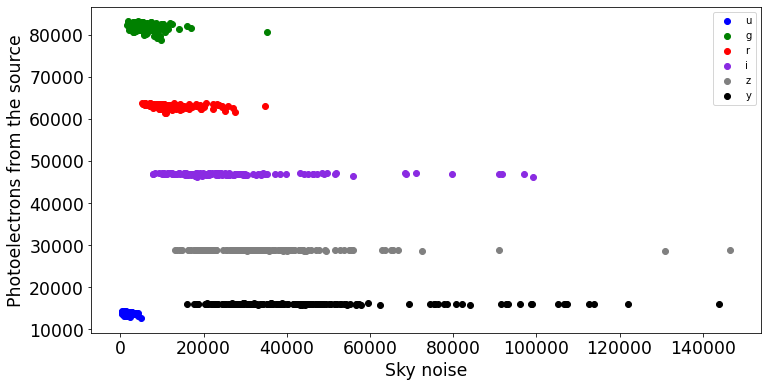

In [60]:
plt.scatter(N_pe_u, all_count_u, color = 'b', label = 'u')
plt.scatter(N_pe_g, all_count_g, color = 'g', label = 'g')
plt.scatter(N_pe_r, all_count_r, color = 'r', label = 'r')
plt.scatter(N_pe_i, all_count_i, color = 'blueviolet', label = 'i')
plt.scatter(N_pe_z, all_count_z, color = 'grey', label = 'z')
plt.scatter(N_pe_y, all_count_y, color = 'k', label = 'y')
plt.xlabel("Sky noise")
plt.ylabel("Photoelectrons from the source")
plt.legend()

# Photometric error

$$
    N = \sqrt{N_{pe} + F}
$$

where 

$N_{pe}$ is the background noise 

F is the source flux  

N the photometric error

In [61]:
N = []
N_u = []
N_g = []
N_r = []
N_i = []
N_z = []
N_y = []

for i in range (len(bp_atmo)) :
    
    N.append(np.sqrt(N_pe[i] + all_count[i]))
    
for i in range (len(N_pe_u)) :
    
    N_u.append(np.sqrt(N_pe_u[i] + all_count_u[i]))
    
for i in range (len(N_pe_g)) :
    
    N_g.append(np.sqrt(N_pe_g[i] + all_count_g[i]))
    
for i in range (len(N_pe_r)) :
    
    N_r.append(np.sqrt(N_pe_r[i] + all_count_r[i]))
    
for i in range (len(N_pe_i)) :
    
    N_i.append(np.sqrt(N_pe_i[i] + all_count_i[i]))
    
for i in range (len(N_pe_z)) :
    
    N_z.append(np.sqrt(N_pe_z[i] + all_count_z[i]))
    
for i in range (len(N_pe_y)) :
    
    N_y.append(np.sqrt(N_pe_y[i] + all_count_y[i]))

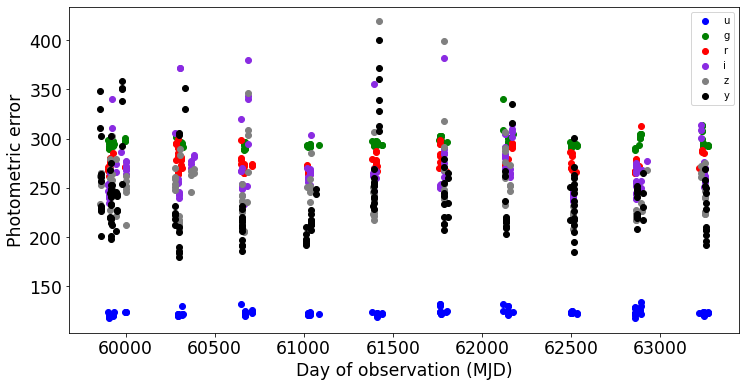

In [62]:
plt.scatter(ObservationStartMJD_u, N_u, color = 'b', label = 'u')
plt.scatter(ObservationStartMJD_g, N_g, color = 'g', label = 'g')
plt.scatter(ObservationStartMJD_r, N_r, color = 'r', label = 'r')
plt.scatter(ObservationStartMJD_i, N_i, color = 'blueviolet', label = 'i')
plt.scatter(ObservationStartMJD_z, N_z, color = 'grey', label = 'z')
plt.scatter(ObservationStartMJD_y, N_y, color = 'k', label = 'y')
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Photometric error")
plt.legend()

Text(0.5, 1.0, 'Number of captured photoelectrons for observations in the u band (with photometric errors)')

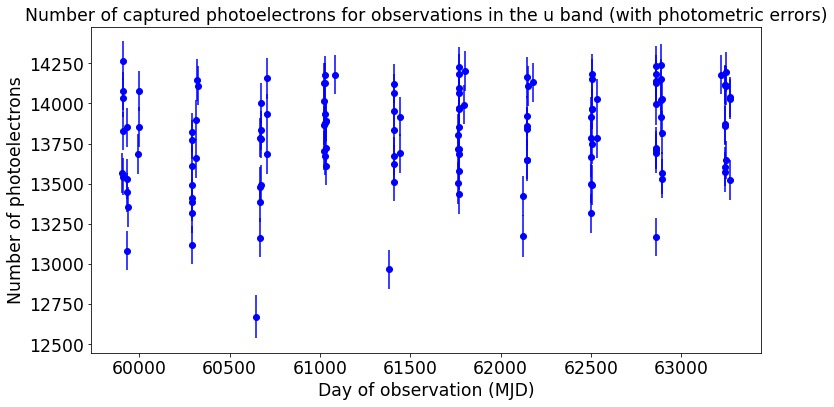

In [63]:
plt.errorbar(ObservationStartMJD_u, all_count_u, N_u, fmt="o", color = 'b')
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Number of photoelectrons")
plt.title("Number of captured photoelectrons for observations in the u band (with photometric errors)")

Text(0.5, 1.0, 'Number of captured photoelectrons for observations in the g band (with photometric errors)')

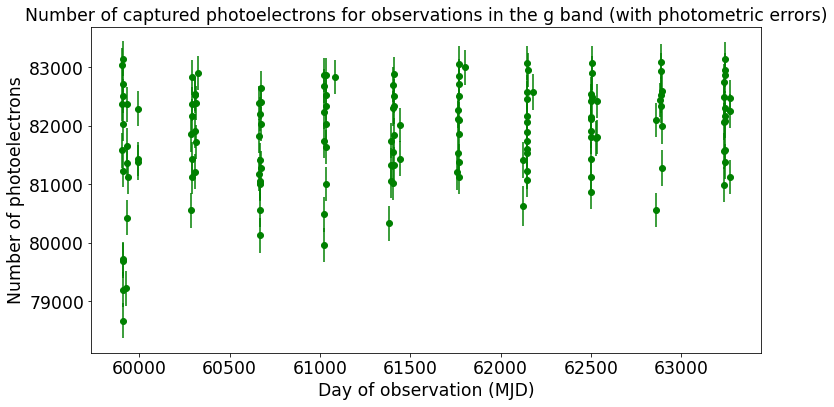

In [64]:
plt.errorbar(ObservationStartMJD_g, all_count_g, N_g, fmt="o", color = 'g')
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Number of photoelectrons")
plt.title("Number of captured photoelectrons for observations in the g band (with photometric errors)")

Text(0.5, 1.0, 'Number of captured photoelectrons for observations in the r band (with photometric errors)')

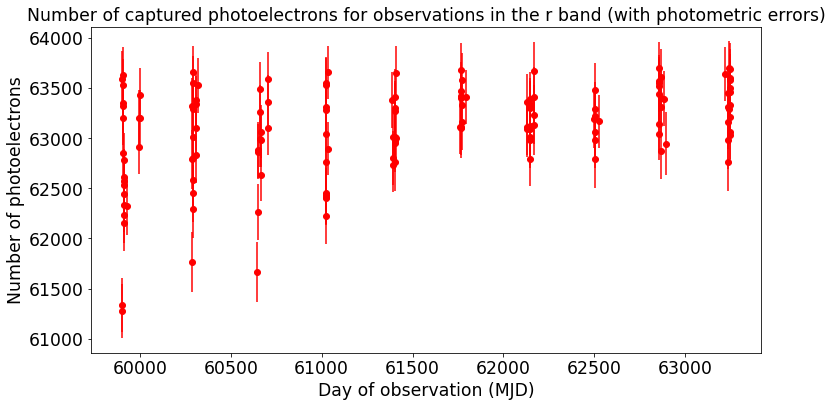

In [65]:
plt.errorbar(ObservationStartMJD_r, all_count_r, N_r, fmt="o", color = 'r')
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Number of photoelectrons")
plt.title("Number of captured photoelectrons for observations in the r band (with photometric errors)")

Text(0.5, 1.0, 'Number of captured photoelectrons for observations in the i band (with photometric errors)')

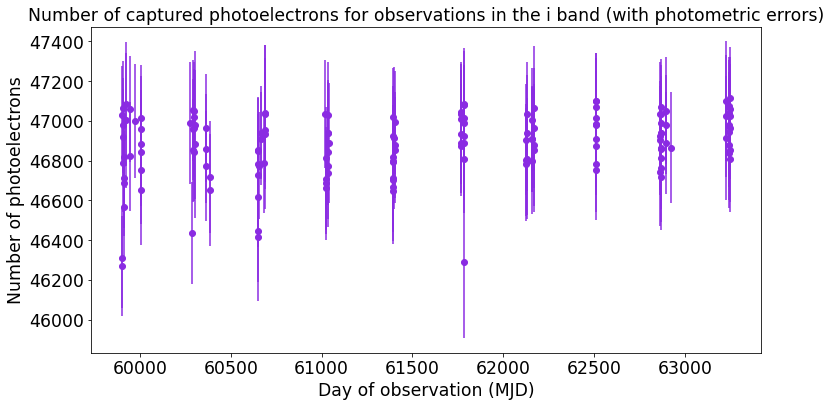

In [66]:
plt.errorbar(ObservationStartMJD_i, all_count_i, N_i, fmt="o", color = 'blueviolet')
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Number of photoelectrons")
plt.title("Number of captured photoelectrons for observations in the i band (with photometric errors)")

Text(0.5, 1.0, 'Number of captured photoelectrons for observations in the z band (with photometric errors)')

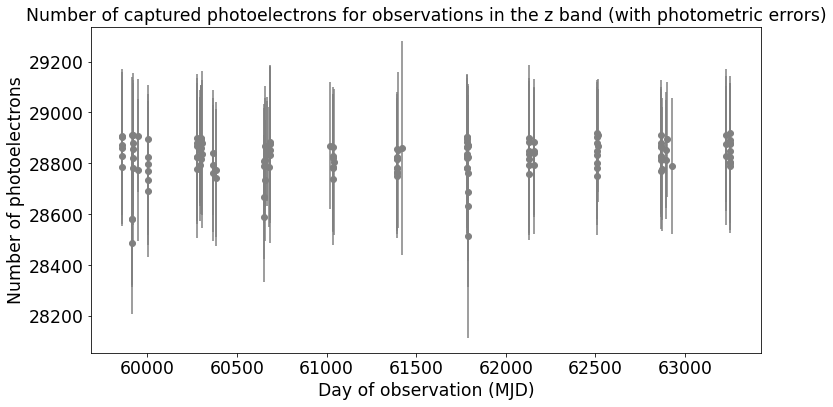

In [67]:
plt.errorbar(ObservationStartMJD_z, all_count_z, N_z, fmt="o", color = 'grey')
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Number of photoelectrons")
plt.title("Number of captured photoelectrons for observations in the z band (with photometric errors)")

Text(0.5, 1.0, 'Number of captured photoelectrons for observations in the y band (with photometric errors)')

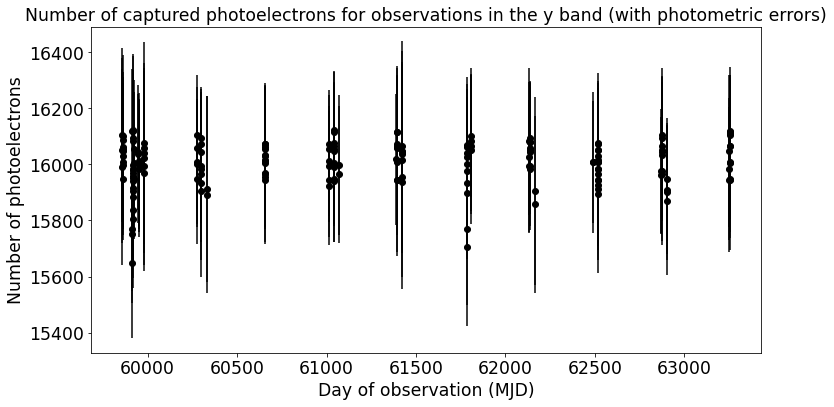

In [68]:
plt.errorbar(ObservationStartMJD_y, all_count_y, N_y, fmt="o", color = 'k')
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Number of photoelectrons")
plt.title("Number of captured photoelectrons for observations in the y band (with photometric errors)")

# Amplitude error

$$
\sigma_A = \frac{\sigma_N \times A(t)}{F}
$$

In [69]:
def u(t):
    return np.sqrt(u0**2+ ((t-t0)/tE)**2)

In [70]:
def A(u):
    return (u**2+2)/u/np.sqrt(u**2+4)

In [71]:
amp_err = []
amp_err_u = []
amp_err_g = []
amp_err_r = []
amp_err_i = []
amp_err_z = []
amp_err_y = []

for i in range (len(all_count)) :
    
    amp_err.append(N[i] * A(u(df['observationStartMJD'][i]))/all_count[i])

for i in range (len(all_count_u)) :
        
    amp_err_u.append(N_u[i] * A(u(ObservationStartMJD_u[i]))/all_count_u[i])
        
for i in range (len(all_count_g)) :
        
    amp_err_g.append(N_g[i] * A(u(ObservationStartMJD_g[i]))/all_count_g[i])
    
for i in range (len(all_count_r)) :
        
    amp_err_r.append(N_r[i] * A(u(ObservationStartMJD_r[i]))/all_count_r[i])
    
for i in range (len(all_count_i)) :
        
    amp_err_i.append(N_i[i] * A(u(ObservationStartMJD_i[i]))/all_count_i[i])
    
for i in range (len(all_count_z)) :
        
    amp_err_z.append(N_z[i] * A(u(ObservationStartMJD_z[i]))/all_count_z[i])
    
for i in range (len(all_count_y)) :
        
    amp_err_y.append(N_y[i] * A(u(ObservationStartMJD_y[i]))/all_count_y[i])


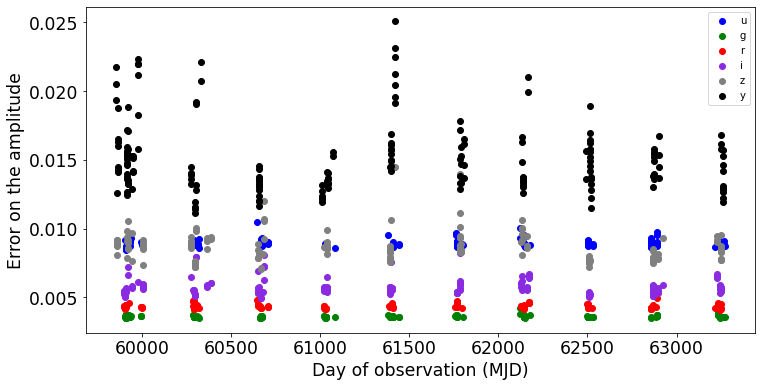

In [72]:
plt.scatter(ObservationStartMJD_u, amp_err_u, color = 'b', label = 'u')
plt.scatter(ObservationStartMJD_g, amp_err_g, color = 'g', label = 'g')
plt.scatter(ObservationStartMJD_r, amp_err_r, color = 'r', label = 'r')
plt.scatter(ObservationStartMJD_i, amp_err_i, color = 'blueviolet', label = 'i')
plt.scatter(ObservationStartMJD_z, amp_err_z, color = 'grey', label = 'z')
plt.scatter(ObservationStartMJD_y, amp_err_y, color = 'k', label = 'y')
plt.xlabel("Day of observation (MJD)")
plt.ylabel("Error on the amplitude")
plt.legend()

# Plotting the light curve and Microlensing fit with expected errors

t0 = 62060.86964525595
tE = 20
u0 = 1.8965590040667037


(61960.86964525595, 62160.86964525595)

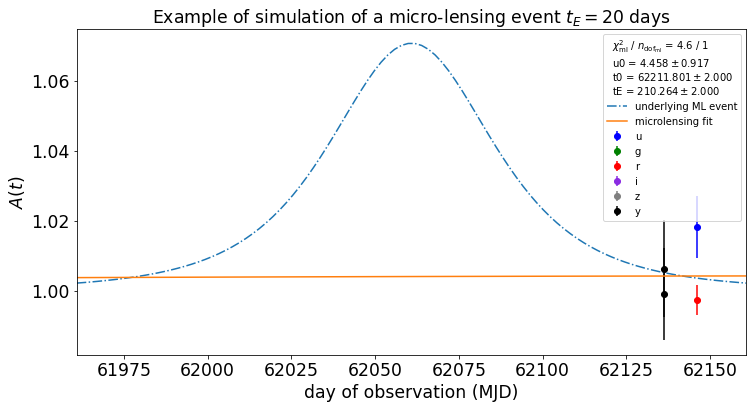

In [102]:
#Randomize parameters

from random import *

u0 = umin[randrange(len(umin))]
t0 = list_t0[randrange(len(list_t0))] 

#tE distribution or value

tE = 20

#Time t 

tmin=t0-5.*tE
tmax=t0+5.*tE
ti=np.linspace(tmin,tmax,100)


print("t0 = {}".format(t0)) #Display values
print("tE = {}".format(tE))
print("u0 = {}".format(u0))



#We distinguish data points by filter

df_event_u = df[(df["filter"] == "u") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event_g = df[(df["filter"] == "g") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event_r = df[(df["filter"] == "r") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event_i = df[(df["filter"] == "i") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]  
df_event_z = df[(df["filter"] == "z") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)]  
df_event_y = df[(df["filter"] == "y") & (df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 
df_event = df[(df["observationStartMJD"] >= tmin) & (df["observationStartMJD"] <= tmax) & ((df['fieldRA'] - galaxy_ra)**2 + (df['fieldDec'] - galaxy_dec)**2 < Circle.radius.value**2)] 

df_event_times = df_event["observationStartMJD"].values
df_event_times_u = df_event_u["observationStartMJD"].values 
df_event_times_g = df_event_g["observationStartMJD"].values
df_event_times_r = df_event_r["observationStartMJD"].values
df_event_times_i = df_event_i["observationStartMJD"].values
df_event_times_z = df_event_z["observationStartMJD"].values
df_event_times_y = df_event_y["observationStartMJD"].values


#Photometric Error


    

amp_err = []
amp_err_u = []
amp_err_g = []
amp_err_r = []
amp_err_i = []
amp_err_z = []
amp_err_y = []

for i in range (len(df['observationStartMJD'])) :
    
    if (df["observationStartMJD"].values[i] >= tmin) & (df["observationStartMJD"].values[i] <= tmax) & ((df['fieldRA'][i] - galaxy_ra)**2 + (df['fieldDec'][i] - galaxy_dec)**2 < Circle.radius.value**2) :
        
        amp_err.append(N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
    
        if (df['filter'].values[i] == 'u') :
        
            
            amp_err_u.append(N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
       
        if (df['filter'].values[i] == 'g') :
        
            
            amp_err_g.append(N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
        
        if (df['filter'].values[i] == 'r') :
        
            
            amp_err_r.append(N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
        
        if (df['filter'].values[i] == 'i') :
        
            
            amp_err_i.append(N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
        
        if (df['filter'].values[i] == 'z') :
        
            
            amp_err_z.append(N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
        
        if (df['filter'].values[i] == 'y') :
        
            
            amp_err_y.append(N[i] * A(u(df['observationStartMJD'].values[i]))/all_count[i])
    



#Underlying ML event

plt.plot(ti,A(u(ti)),"-.",label="underlying ML event")


# Microlensing fit with iMinuit

x = df_event_times       
x_u = df_event_times_u
x_g = df_event_times_g
x_r = df_event_times_r
x_i = df_event_times_i
x_z = df_event_times_z
x_y = df_event_times_y

y_data = A(u(df_event_times))

y = y_data + amp_err * np.random.randn(len(x))
y_u = A(u(df_event_times_u)) + amp_err_u * np.random.randn(len(x_u))
y_g = A(u(df_event_times_g)) + amp_err_g * np.random.randn(len(x_g))
y_r = A(u(df_event_times_r)) + amp_err_r * np.random.randn(len(x_r))
y_i = A(u(df_event_times_i)) + amp_err_i * np.random.randn(len(x_i))
y_z = A(u(df_event_times_z)) + amp_err_z * np.random.randn(len(x_z))
y_y = A(u(df_event_times_y)) + amp_err_y * np.random.randn(len(x_y))


plt.errorbar(x_u, y_u, amp_err_u, fmt="o", label="u", color = "b")  #Show data points with their respective photometric error
plt.errorbar(x_g, y_g, amp_err_g, fmt="o", label="g", color = "g")  #Color depends on the filter
plt.errorbar(x_r, y_r, amp_err_r, fmt="o", label="r", color = "r")
plt.errorbar(x_i, y_i, amp_err_i, fmt="o", label="i", color = "blueviolet")
plt.errorbar(x_z, y_z, amp_err_z, fmt="o", label="z", color ="grey")
plt.errorbar(x_y, y_y, amp_err_y, fmt="o", label="y", color ="k")

least_squares = LeastSquares(x, y, amp_err, Ab)        # Fit using the least squares method
m = Minuit(least_squares, u0 = u0, t0 = t0, tE = tE)  #starting values for our parameters


m.migrad() # finds minimum of least_squares function
m.hesse()  # accurately computes uncertainties

plt.plot(ti, Ab(ti, *m.values), label="microlensing fit") 


#Plot legend etc

fit_info = [
    f"$\\chi^2_\\mathrm{{ml}}$ / $n_\\mathrm{{dof_\\mathrm{{ml}}}}$ = {m.fval:.1f} / {len(x) - m.nfit}",    #Display fit info  
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

plt.xlabel("day of observation (MJD)")
plt.ylabel("$A(t)$")
plt.title("Example of simulation of a micro-lensing event $t_E = 20$ days")
plt.legend(title="\n".join(fit_info))
plt.xlim(tmin,tmax)

(59797.459970687785, 59997.459970687785)

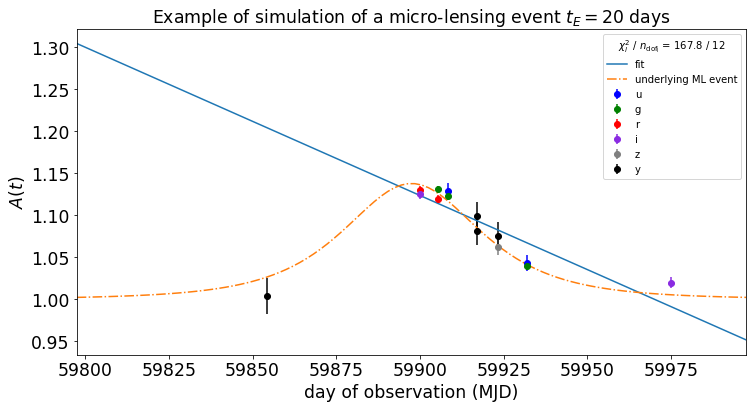

In [97]:
least_squares_line = LeastSquares(x, y, amp_err, linear) #linear least squares
m_line = Minuit(least_squares_line, alpha=1, beta=1)  

m_line.migrad() # finds minimum of least_squares function
m_line.hesse()  # accurately computes uncertainties

plt.errorbar(x_u, y_u, amp_err_u, fmt="o", label="u", color = "b")  #Show data points with their respective photometric error
plt.errorbar(x_g, y_g, amp_err_g, fmt="o", label="g", color = "g")  #Color depends on the filter
plt.errorbar(x_r, y_r, amp_err_r, fmt="o", label="r", color = "r")
plt.errorbar(x_i, y_i, amp_err_i, fmt="o", label="i", color = "blueviolet")
plt.errorbar(x_z, y_z, amp_err_z, fmt="o", label="z", color ="grey")
plt.errorbar(x_y, y_y, amp_err_y, fmt="o", label="y", color ="k")
plt.plot(ti, linear(ti, *m_line.values), label="fit")
plt.plot(ti,A(u(ti)),"-.",label="underlying ML event")


fit_info = [
    f"$\\chi^2_l$ / $n_\\mathrm{{dof_l}}$ = {m_line.fval:.1f} / {len(x) - m_line.nfit}",     #Display fit info
]
plt.xlabel("day of observation (MJD)")
plt.ylabel("$A(t)$")
plt.title("Example of simulation of a micro-lensing event $t_E = 20$ days")
plt.legend(title="\n".join(fit_info))
plt.xlim(tmin,tmax)

In [98]:
(m_line.fval - m.fval)/np.sqrt(2*(len(x)- m.nfit)) 

34.08468856925265